# ⚽ Real Madrid Match Predictor — Production Grade
### La Liga 2021-22 · 2022-23 · 2023-24 · 2024-25

| | |
|---|---|
| **Fuente de datos** | [football-data.co.uk](https://www.football-data.co.uk/spainm.php) — CSV públicos |
| **Validación de esquema** | `pandera` |
| **Pipeline ML** | `scikit-learn` con `TimeSeriesSplit` |
| **Serialización** | `joblib` |
| **Logging** | módulo estándar Python |

```
real_madrid_predictor/
├── real_madrid_production.ipynb
├── data/raw/            ← CSVs originales de football-data.co.uk
├── data/processed/      ← parquet limpio
├── models/              ← artefacto joblib
└── logs/                ← trazabilidad
```


## 0 · Dependencias


In [1]:
%pip install pandera scikit-learn joblib pandas numpy matplotlib
print("✅ Dependencias listas")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.9/295.9 kB 5.1 MB/s eta 0:00:00
✅ Dependencias listas


## 1 · Configuración centralizada

Todos los parámetros en un único `Config` como fuente de verdad.
En CI/CD se inyecta desde variables de entorno o `config.yaml`.


In [2]:
from __future__ import annotations

import io
import logging
import warnings
from dataclasses import dataclass, field
from pathlib import Path
from typing import Final, Optional
import urllib.request

import joblib
import numpy as np
import pandas as pd
import pandera as pa
from pandera.typing import Series
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                              confusion_matrix, f1_score)
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

warnings.filterwarnings('ignore')

# ── Paths ────────────────────────────────────────────────────────────────────
ROOT       : Final = Path('.')
DATA_RAW   : Final = ROOT / 'data' / 'raw'
DATA_PROC  : Final = ROOT / 'data' / 'processed'
MODELS_DIR : Final = ROOT / 'models'
LOGS_DIR   : Final = ROOT / 'logs'

for d in (DATA_RAW, DATA_PROC, MODELS_DIR, LOGS_DIR):
    d.mkdir(parents=True, exist_ok=True)

# ── Logging ──────────────────────────────────────────────────────────────────
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s  %(levelname)-8s  %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler(LOGS_DIR / 'pipeline.log', mode='a'),
    ],
)
log = logging.getLogger('rm_predictor')

# ── Config ───────────────────────────────────────────────────────────────────
@dataclass(frozen=True)
class Config:
    team: str = 'Real Madrid'

    # Temporadas y URLs de football-data.co.uk
    # CSV público, sin scraping, sin API key, actualizado cada semana
    season_urls: dict = field(default_factory=lambda: {
        '2021-22': 'https://www.football-data.co.uk/mmz4281/2122/SP1.csv',
        '2022-23': 'https://www.football-data.co.uk/mmz4281/2223/SP1.csv',
        '2023-24': 'https://www.football-data.co.uk/mmz4281/2324/SP1.csv',
        '2024-25': 'https://www.football-data.co.uk/mmz4281/2425/SP1.csv',
    })

    # Columnas disponibles en football-data.co.uk
    stat_cols: tuple = ('gf', 'ga', 'sh', 'sot', 'fouls', 'corners')

    roll_window: int  = 5
    cutoff: str       = '2024-07-01'  # inicio temp 24-25 → hold-out
    n_splits: int     = 4

    rf_params: dict = field(default_factory=lambda: {
        'n_estimators':      400,
        'max_depth':         8,
        'min_samples_split': 6,
        'min_samples_leaf':  3,
        'class_weight':      'balanced',
        'random_state':      42,
        'n_jobs':           -1,
    })

    model_path: Path = MODELS_DIR / 'rf_pipeline.joblib'


CFG = Config()
log.info('Config cargada: %d temporadas, ventana=%d', len(CFG.season_urls), CFG.roll_window)
print(CFG)


Config(team='Real Madrid', season_urls={'2021-22': 'https://www.football-data.co.uk/mmz4281/2122/SP1.csv', '2022-23': 'https://www.football-data.co.uk/mmz4281/2223/SP1.csv', '2023-24': 'https://www.football-data.co.uk/mmz4281/2324/SP1.csv', '2024-25': 'https://www.football-data.co.uk/mmz4281/2425/SP1.csv'}, stat_cols=('gf', 'ga', 'sh', 'sot', 'fouls', 'corners'), roll_window=5, cutoff='2024-07-01', n_splits=4, rf_params={'n_estimators': 400, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 3, 'class_weight': 'balanced', 'random_state': 42, 'n_jobs': -1}, model_path=PosixPath('models/rf_pipeline.joblib'))


## 2 · Ingesta de datos reales

**Fuente:** [football-data.co.uk](https://www.football-data.co.uk/spainm.php)  
CSVs con resultados y estadísticas de toda La Liga.

| CSV original | Nombre interno | Descripción |
|---|---|---|
| `FTHG` / `FTAG` | `gf` / `ga` | Goles a favor / en contra |
| `HS` / `AS` | `sh` | Tiros totales |
| `HST` / `AST` | `sot` | Tiros a puerta |
| `HF` / `AF` | `fouls` | Faltas cometidas |
| `HC` / `AC` | `corners` | Córners |
| `B365H/D/A` | `odds_*` | Cuotas Bet365 (feature de dificultad) |


In [3]:
# Mapeo de columnas CSV → nombres internos (perspectiva Real Madrid)
COL_MAP_HOME = {
    'Date': 'date', 'HomeTeam': 'team', 'AwayTeam': 'opponent',
    'FTHG': 'gf',   'FTAG': 'ga',       'FTR': 'ftr',
    'HS':   'sh',   'HST': 'sot',
    'HF':   'fouls','HC':  'corners',
    'B365H': 'odds_win', 'B365D': 'odds_draw', 'B365A': 'odds_loss',
}
COL_MAP_AWAY = {
    'Date': 'date', 'AwayTeam': 'team', 'HomeTeam': 'opponent',
    'FTAG': 'gf',   'FTHG': 'ga',       'FTR': 'ftr',
    'AS':   'sh',   'AST': 'sot',
    'AF':   'fouls','AC':  'corners',
    'B365A': 'odds_win', 'B365D': 'odds_draw', 'B365H': 'odds_loss',
}
KEEP_COLS = ['date','team','opponent','venue','result','season',
             'gf','ga','sh','sot','fouls','corners',
             'odds_win','odds_draw','odds_loss']


def _download_csv(url: str, season: str) -> pd.DataFrame:
    cache = DATA_RAW / f"SP1_{season.replace('-','')}.csv"
    if cache.exists():
        log.info('Cache hit: %s', cache.name)
        return pd.read_csv(cache, encoding='latin-1')
    log.info('Descargando %s → %s', season, url)
    try:
        with urllib.request.urlopen(url, timeout=15) as resp:
            raw = resp.read()
        cache.write_bytes(raw)
        return pd.read_csv(io.BytesIO(raw), encoding='latin-1')
    except Exception as exc:
        raise ConnectionError(
            f'No se pudo descargar {url}\n'
            f'Comprueba tu conexión a internet.\n'
            f'Error: {exc}'
        ) from exc


def _extract_team(df_raw: pd.DataFrame, team: str, season: str) -> pd.DataFrame:
    home = df_raw[df_raw['HomeTeam'] == team].rename(columns=COL_MAP_HOME).copy()
    away = df_raw[df_raw['AwayTeam'] == team].rename(columns=COL_MAP_AWAY).copy()
    home['venue'] = 'Home'
    away['venue'] = 'Away'
    home['result'] = home['ftr'].map({'H': 'W', 'D': 'D', 'A': 'L'})
    away['result'] = away['ftr'].map({'A': 'W', 'D': 'D', 'H': 'L'})
    home['season'] = away['season'] = season
    combined = pd.concat([
        home[[c for c in KEEP_COLS if c in home.columns]],
        away[[c for c in KEEP_COLS if c in away.columns]],
    ], ignore_index=True)
    return combined


def fetch_data(cfg: Config) -> pd.DataFrame:
    frames = []
    for season, url in cfg.season_urls.items():
        df_raw  = _download_csv(url, season)
        df_team = _extract_team(df_raw, cfg.team, season)
        frames.append(df_team)
        log.info('  %s → %d partidos de %s', season, len(df_team), cfg.team)
    df = pd.concat(frames, ignore_index=True)
    df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
    df = df.sort_values('date').reset_index(drop=True)
    out = DATA_RAW / 'rm_matches_raw.parquet'
    df.to_parquet(out, index=False)
    log.info('Raw consolidado → %s (%d filas)', out, len(df))
    return df


raw_df = fetch_data(CFG)
print(f'\n📊 Partidos descargados: {len(raw_df)}')
print(f'📅 Rango: {raw_df["date"].min().date()} → {raw_df["date"].max().date()}')
raw_df.head(5)



📊 Partidos descargados: 152
📅 Rango: 2021-08-14 → 2025-05-24


,date,team,opponent,venue,result,season,gf,ga,sh,sot,fouls,corners,odds_win,odds_draw,odds_loss
0,2021-08-14,Real Madrid,Alaves,Away,W,2021-22,4,1,19,7,10,4,1.44,4.75,7.0
1,2021-08-22,Real Madrid,Levante,Away,D,2021-22,3,3,19,5,7,6,1.60,4.33,5.0
2,2021-08-28,Real Madrid,Betis,Away,W,2021-22,1,0,13,3,13,7,1.80,3.80,4.2
3,2021-09-12,Real Madrid,Celta,Home,W,2021-22,5,2,15,11,8,7,1.36,5.25,8.0
4,2021-09-19,Real Madrid,Valencia,Away,W,2021-22,2,1,18,10,14,5,1.90,3.80,3.8


## 3 · Validación de esquema con Pandera

Contrato de datos explícito. Si football-data.co.uk cambia su formato
o un CSV llega corrupto, el pipeline **falla con un mensaje claro**
en lugar de producir predicciones silenciosamente incorrectas.


In [4]:
class RawMatchSchema(pa.DataFrameModel):
    date:     Series[pa.typing.DateTime]
    team:     Series[str]   = pa.Field(isin=['Real Madrid'])
    opponent: Series[str]   = pa.Field(str_length={'min_value': 2})
    venue:    Series[str]   = pa.Field(isin=['Home', 'Away'])
    result:   Series[str]   = pa.Field(isin=['W', 'D', 'L'])
    gf:       Series[float] = pa.Field(ge=0, le=15, nullable=True)
    ga:       Series[float] = pa.Field(ge=0, le=15, nullable=True)
    sh:       Series[float] = pa.Field(ge=0, le=60, nullable=True)
    sot:      Series[float] = pa.Field(ge=0, le=30, nullable=True)
    fouls:    Series[float] = pa.Field(ge=0, le=30, nullable=True)
    corners:  Series[float] = pa.Field(ge=0, le=20, nullable=True)

    class Config:
        coerce            = True
        drop_invalid_rows = True


def validate_and_clean(df: pd.DataFrame) -> pd.DataFrame:
    log.info('Iniciando validación...')
    n0 = len(df)

    # Correcciones de consistencia lógica
    mask_sot = df['sot'] > df['sh']
    if mask_sot.any():
        log.warning('sot > sh en %d filas — recortando', mask_sot.sum())
        df.loc[mask_sot, 'sot'] = df.loc[mask_sot, 'sh']

    # Resultado recalculado desde goles (fuente de verdad más fiable que FTR)
    df['result'] = df.apply(
        lambda r: 'W' if r.gf > r.ga else ('D' if r.gf == r.ga else 'L'), axis=1)

    # Duplicados
    n_dup = df.duplicated(subset=['date', 'team', 'opponent']).sum()
    if n_dup:
        log.warning('Eliminando %d duplicados', n_dup)
        df = df.drop_duplicates(subset=['date', 'team', 'opponent'])

    # Validación de esquema — falla ruidosamente si hay errores
    try:
        df = RawMatchSchema.validate(df, lazy=True)
    except pa.errors.SchemaErrors as exc:
        log.error('Errores de validación:\n%s', exc.failure_cases.to_string())
        raise

    df = df.sort_values('date').reset_index(drop=True)
    log.info('Validación OK: %d → %d filas (%d eliminadas)', n0, len(df), n0 - len(df))
    return df


clean_df = validate_and_clean(raw_df.copy())
print(f'✅ Registros válidos:  {len(clean_df)}')
print(f'🔢 Nulos por columna:')
print(clean_df[list(CFG.stat_cols)].isnull().sum().to_string())
clean_df.dtypes


✅ Registros válidos:  151
🔢 Nulos por columna:
gf         0
ga         0
sh         0
sot        0
fouls      0
corners    0


,0
date,datetime64[ns]
team,object
opponent,object
venue,object
result,object
season,object
gf,float64
ga,float64
sh,float64
sot,float64


## 4 · Análisis exploratorio


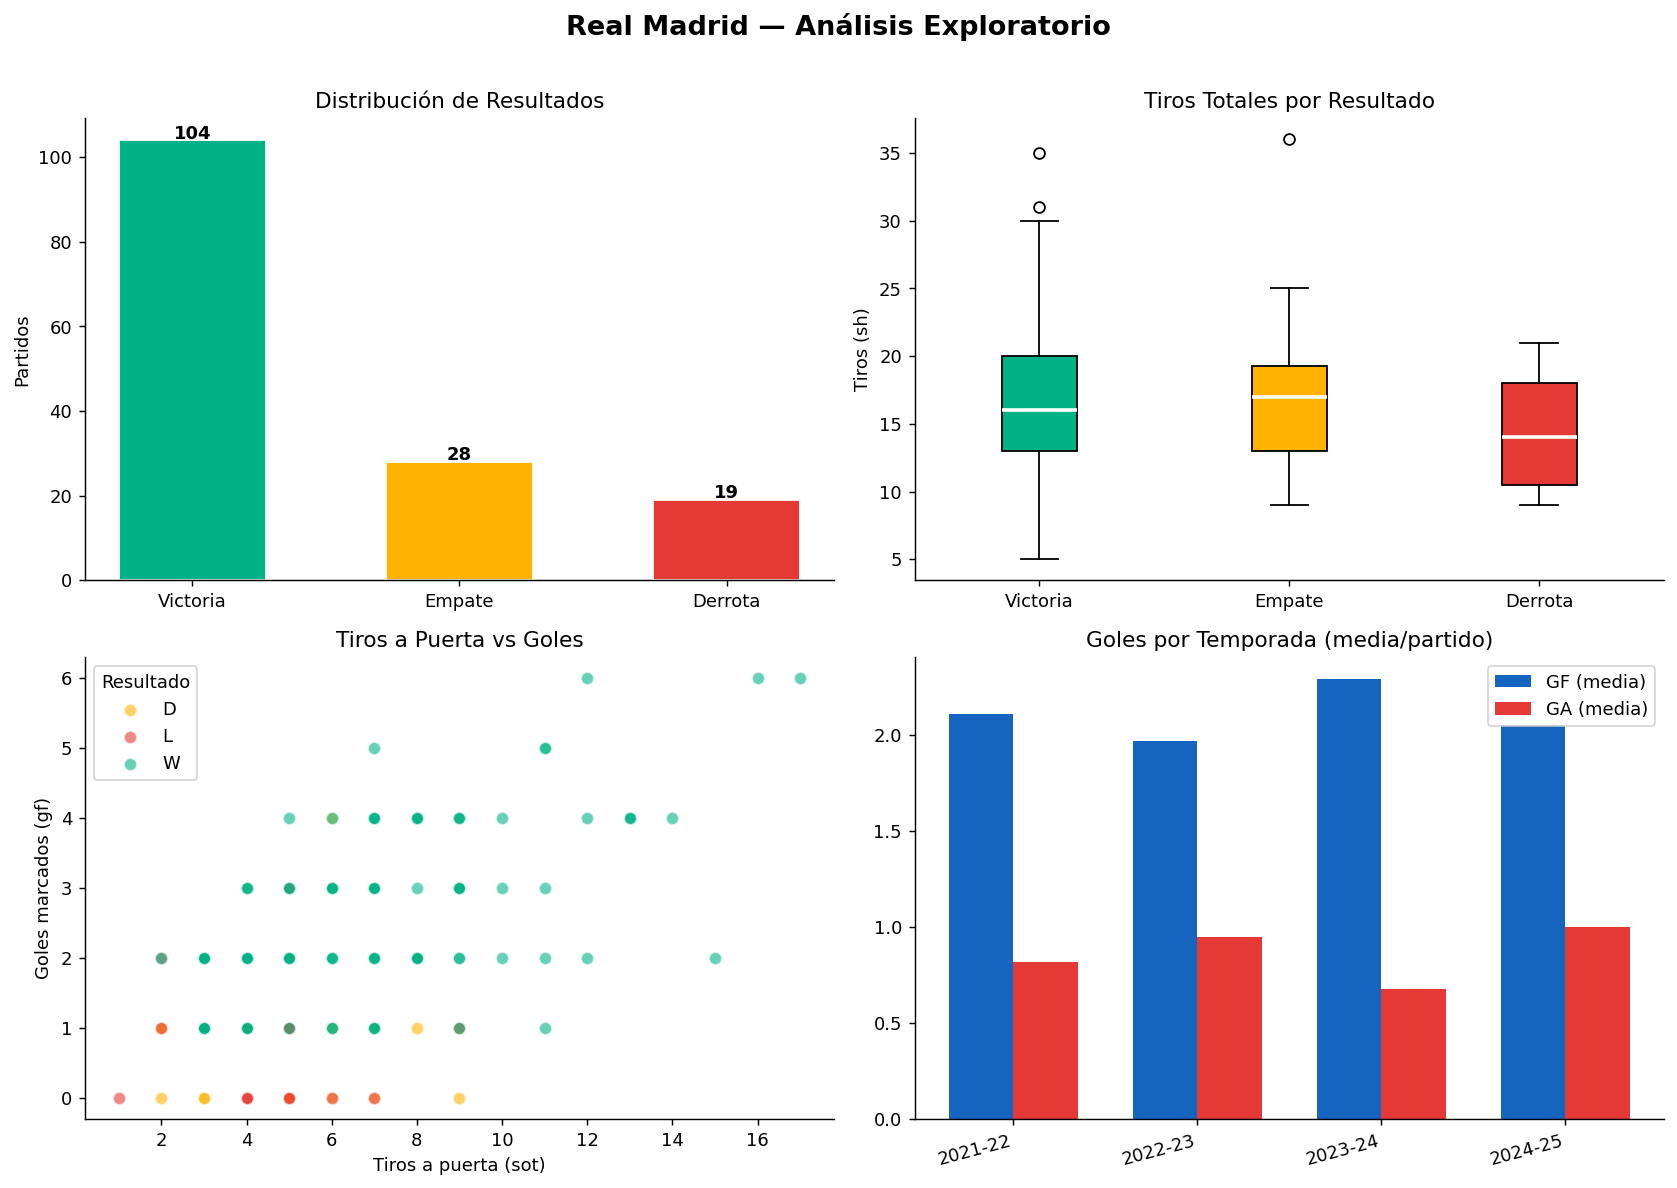

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.rcParams.update({
    'figure.dpi': 130,
    'axes.spines.top': False,
    'axes.spines.right': False,
})
PALETTE = {'W': '#00B386', 'D': '#FFB300', 'L': '#E53935'}

fig, axes = plt.subplots(2, 2, figsize=(13, 9))
fig.suptitle('Real Madrid — Análisis Exploratorio', fontsize=15, fontweight='bold', y=1.01)

# 1. Distribución de resultados
ax = axes[0, 0]
counts = clean_df['result'].value_counts().reindex(['W','D','L'])
ax.bar(['Victoria','Empate','Derrota'], counts,
       color=[PALETTE[k] for k in ['W','D','L']], edgecolor='white', width=0.55)
for i, v in enumerate(counts):
    ax.text(i, v + 0.4, str(v), ha='center', fontweight='bold')
ax.set_title('Distribución de Resultados')
ax.set_ylabel('Partidos')

# 2. Tiros por resultado
ax = axes[0, 1]
data_box = [clean_df[clean_df['result'] == r]['sh'].dropna() for r in ['W','D','L']]
bp = ax.boxplot(data_box, patch_artist=True,
                medianprops=dict(color='white', linewidth=2))
for patch, r in zip(bp['boxes'], ['W','D','L']):
    patch.set_facecolor(PALETTE[r])
ax.set_xticklabels(['Victoria','Empate','Derrota'])
ax.set_title('Tiros Totales por Resultado')
ax.set_ylabel('Tiros (sh)')

# 3. Tiros a puerta vs goles
ax = axes[1, 0]
for res, grp in clean_df.groupby('result'):
    ax.scatter(grp['sot'], grp['gf'], label=res,
               color=PALETTE[res], alpha=0.6, edgecolors='white', s=50)
ax.set_xlabel('Tiros a puerta (sot)')
ax.set_ylabel('Goles marcados (gf)')
ax.set_title('Tiros a Puerta vs Goles')
ax.legend(title='Resultado')

# 4. Goles por temporada
ax = axes[1, 1]
sg = clean_df.groupby('season')[['gf','ga']].mean().round(2)
x  = np.arange(len(sg))
w  = 0.35
ax.bar(x - w/2, sg['gf'], w, label='GF (media)', color='#1565C0')
ax.bar(x + w/2, sg['ga'], w, label='GA (media)', color='#E53935')
ax.set_xticks(x)
ax.set_xticklabels(sg.index, rotation=15, ha='right')
ax.set_title('Goles por Temporada (media/partido)')
ax.legend()

plt.tight_layout()
plt.savefig(DATA_RAW / 'eda.png', bbox_inches='tight')
plt.show()
log.info('EDA completado')


## 5 · Feature Engineering

Transformers custom de sklearn: toda la lógica de preprocesamiento
vive **dentro del pipeline** para que sea imposible hacer data leakage
accidentalmente al reutilizar el modelo en producción.


In [6]:
class RollingStatsTransformer(BaseEstimator, TransformerMixin):
    '''
    Añade rolling averages de las últimas `window` jornadas (sin incluir
    la actual, gracias a .shift(1)) agrupando por equipo.

    Es stateless (fit no hace nada), por lo que aplicar el mismo
    transformer a train y test produce resultados correctos siempre
    que el DataFrame llegue ordenado por fecha.
    '''
    def __init__(self, stat_cols: tuple, window: int = 5):
        self.stat_cols = list(stat_cols)
        self.window    = window

    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        for col in self.stat_cols:
            X[f'{col}_r{self.window}'] = (
                X.groupby('team')[col]
                 .transform(lambda s: s.shift(1)
                                       .rolling(self.window, min_periods=1)
                                       .mean())
            )
        return X


class OddsImpliedProbTransformer(BaseEstimator, TransformerMixin):
    '''
    Convierte cuotas decimales a probabilidades implícitas normalizadas.
    P(i) = (1/odd_i) / sum(1/odd_j)

    Las cuotas del mercado son el mejor predictor externo disponible:
    condensan la información de cientos de analistas profesionales.
    '''
    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        cols = ['odds_win', 'odds_draw', 'odds_loss']
        if not all(c in X.columns for c in cols):
            log.warning('Cuotas no disponibles — omitiendo OddsImpliedProb')
            for c in ['imp_prob_win', 'imp_prob_draw', 'imp_prob_loss']:
                X[c] = np.nan
            return X
        raw   = 1 / X[cols].replace(0, np.nan)
        total = raw.sum(axis=1)
        X['imp_prob_win']  = raw['odds_win']  / total
        X['imp_prob_draw'] = raw['odds_draw'] / total
        X['imp_prob_loss'] = raw['odds_loss'] / total
        return X


def build_features(df: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    df = df.copy()
    df = RollingStatsTransformer(cfg.stat_cols, cfg.roll_window).transform(df)
    df = OddsImpliedProbTransformer().transform(df)
    df['target']      = df['result'].map({'W': 1, 'D': 0, 'L': -1}).astype(int)
    df['venue_code']  = df['venue'].map({'Home': 1, 'Away': 0})
    df['opp_code']    = df['opponent'].astype('category').cat.codes
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month']       = df['date'].dt.month
    df = df.dropna().sort_values('date').reset_index(drop=True)
    out = DATA_PROC / 'rm_features.parquet'
    df.to_parquet(out, index=False)
    log.info('Features guardados → %s (%d filas)', out, len(df))
    return df


feat_df = build_features(clean_df, CFG)

ROLL_FEATS = [f'{c}_r{CFG.roll_window}' for c in CFG.stat_cols]
ODDS_FEATS = ['imp_prob_win', 'imp_prob_draw', 'imp_prob_loss']
BASE_FEATS = ['venue_code', 'opp_code', 'day_of_week', 'month']
FEATURES   = BASE_FEATS + ROLL_FEATS + ODDS_FEATS
TARGET     = 'target'

log.info('Features finales (%d): %s', len(FEATURES), FEATURES)
print(f'✅ Dataset listo: {len(feat_df)} filas × {len(FEATURES)} features')
feat_df[['date','opponent','venue','result'] + ROLL_FEATS[:3]].tail(6)


✅ Dataset listo: 150 filas × 13 features


,date,opponent,venue,result,gf_r5,ga_r5,sh_r5
144,2025-04-20,Ath Bilbao,Home,W,1.8,1.2,15.0
145,2025-04-23,Getafe,Away,W,1.6,1.0,17.4
146,2025-05-04,Celta,Home,W,1.4,0.8,18.4
147,2025-05-11,Barcelona,Away,L,1.4,0.8,17.0
148,2025-05-18,Sevilla,Away,W,1.8,1.2,14.6
149,2025-05-24,Sociedad,Home,W,2.0,1.2,15.6


### 5.1 · Correlación de features con el resultado


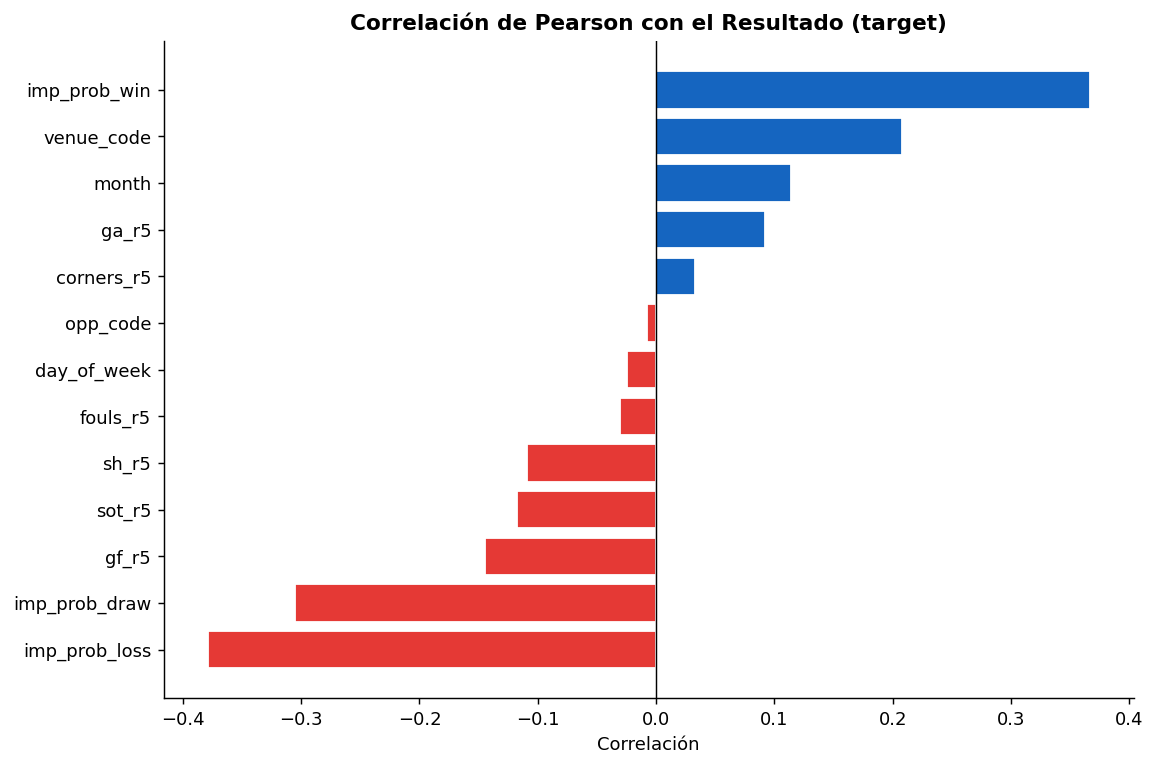

In [7]:
corr = feat_df[FEATURES + [TARGET]].corr()[TARGET].drop(TARGET).sort_values()

fig, ax = plt.subplots(figsize=(9, 6))
colors = ['#E53935' if v < 0 else '#1565C0' for v in corr]
ax.barh(corr.index, corr.values, color=colors, edgecolor='white')
ax.axvline(0, color='black', linewidth=0.8)
ax.set_title('Correlación de Pearson con el Resultado (target)', fontweight='bold')
ax.set_xlabel('Correlación')
plt.tight_layout()
plt.show()


## 6 · Entrenamiento con validación cruzada temporal

- **Train:** temporadas 2021-22, 2022-23, 2023-24  
- **Hold-out:** temporada 2024-25 completa — nunca vista durante el entrenamiento  
- **CV:** `TimeSeriesSplit` sobre el train respetando orden cronológico


🏋️  Train:    113 partidos  (2021-08-22 → 2024-05-25)
🧪  Hold-out: 37 partidos  (2024-08-18 → 2025-05-24)

📊 CV F1-macro por fold: [0.422 0.31  0.507 0.381]
   Media ± std: 0.405 ± 0.071
   Baseline:    0.269


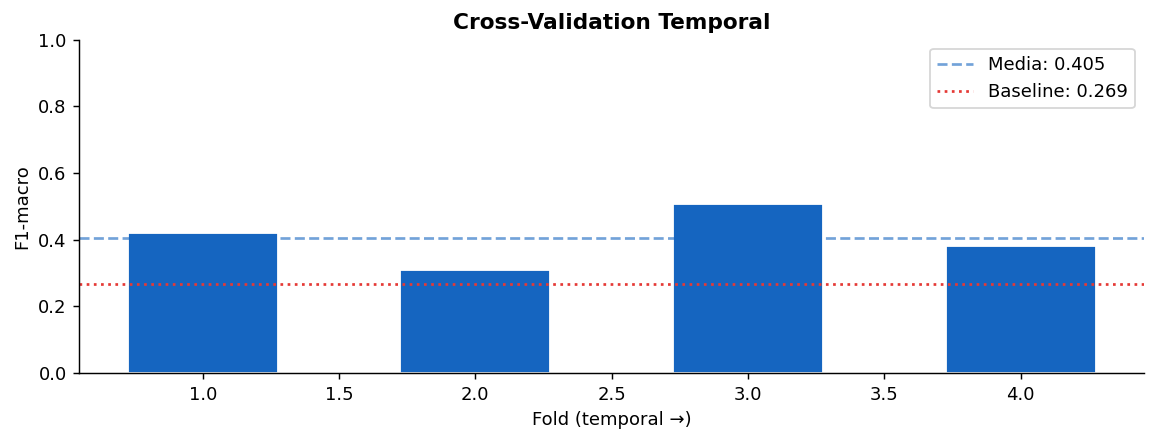

In [8]:
CUTOFF   = pd.Timestamp(CFG.cutoff)
train_df = feat_df[feat_df['date'] < CUTOFF].copy()
test_df  = feat_df[feat_df['date'] >= CUTOFF].copy()

X_train, y_train = train_df[FEATURES], train_df[TARGET]
X_test,  y_test  = test_df[FEATURES],  test_df[TARGET]

log.info('Train: %d | Hold-out: %d', len(train_df), len(test_df))
print(f'🏋️  Train:    {len(train_df)} partidos  '
      f'({train_df["date"].min().date()} → {train_df["date"].max().date()})')
print(f'🧪  Hold-out: {len(test_df)} partidos  '
      f'({test_df["date"].min().date()} → {test_df["date"].max().date()})')

# Baseline (mayoría) para comparar
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train, y_train)
baseline_f1 = f1_score(y_test, dummy.predict(X_test), average='macro', zero_division=0)
log.info('Baseline F1-macro: %.3f', baseline_f1)

# Cross-validation temporal
tscv = TimeSeriesSplit(n_splits=CFG.n_splits)
rf   = RandomForestClassifier(**CFG.rf_params)
cv_scores = cross_val_score(rf, X_train, y_train,
                             cv=tscv, scoring='f1_macro', n_jobs=-1)

log.info('CV F1-macro: %.3f ± %.3f', cv_scores.mean(), cv_scores.std())
print(f'\n📊 CV F1-macro por fold: {cv_scores.round(3)}')
print(f'   Media ± std: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}')
print(f'   Baseline:    {baseline_f1:.3f}')

fig, ax = plt.subplots(figsize=(9, 3.5))
ax.bar(range(1, CFG.n_splits+1), cv_scores,
       color='#1565C0', edgecolor='white', width=0.55)
ax.axhline(cv_scores.mean(), linestyle='--', color='#1565C0', alpha=0.6,
           label=f'Media: {cv_scores.mean():.3f}')
ax.axhline(baseline_f1, linestyle=':', color='#E53935',
           label=f'Baseline: {baseline_f1:.3f}')
ax.set_xlabel('Fold (temporal →)')
ax.set_ylabel('F1-macro')
ax.set_title('Cross-Validation Temporal', fontweight='bold')
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.show()


## 7 · Entrenamiento final + evaluación en hold-out


              precision    recall  f1-score   support

     Derrota       0.50      0.17      0.25         6
      Empate       0.20      0.17      0.18         6
    Victoria       0.70      0.84      0.76        25

    accuracy                           0.62        37
   macro avg       0.47      0.39      0.40        37
weighted avg       0.59      0.62      0.59        37



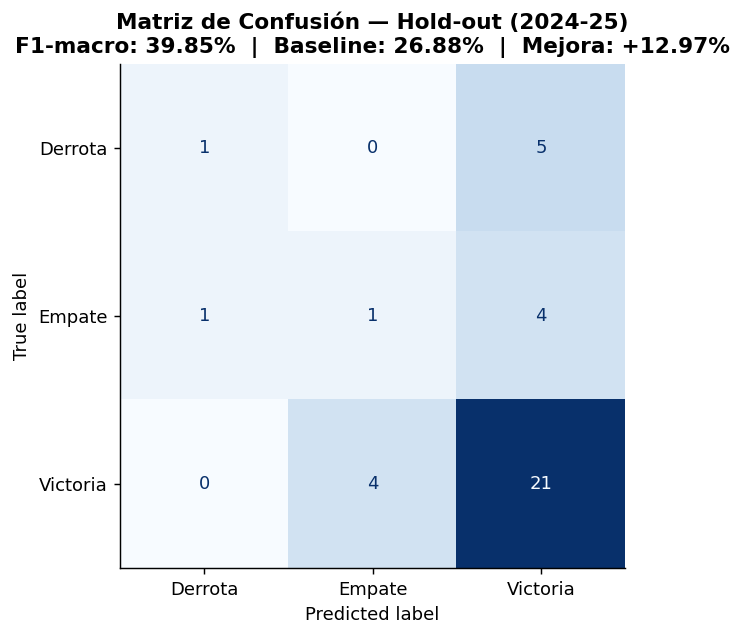

In [9]:
rf.fit(X_train, y_train)
preds   = rf.predict(X_test)
test_f1 = f1_score(y_test, preds, average='macro', zero_division=0)

log.info('Hold-out F1-macro: %.3f (baseline: %.3f, mejora: +%.3f)',
         test_f1, baseline_f1, test_f1 - baseline_f1)

print(classification_report(
    y_test, preds,
    labels=[-1, 0, 1],
    target_names=['Derrota', 'Empate', 'Victoria'],
    zero_division=0,
))

fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay(
    confusion_matrix(y_test, preds, labels=[-1, 0, 1]),
    display_labels=['Derrota', 'Empate', 'Victoria'],
).plot(ax=ax, colorbar=False, cmap='Blues')
ax.set_title(
    f'Matriz de Confusión — Hold-out (2024-25)\n'
    f'F1-macro: {test_f1:.2%}  |  Baseline: {baseline_f1:.2%}  |  '
    f'Mejora: +{test_f1 - baseline_f1:.2%}',
    fontweight='bold',
)
plt.tight_layout()
plt.show()


## 8 · Importancia de variables


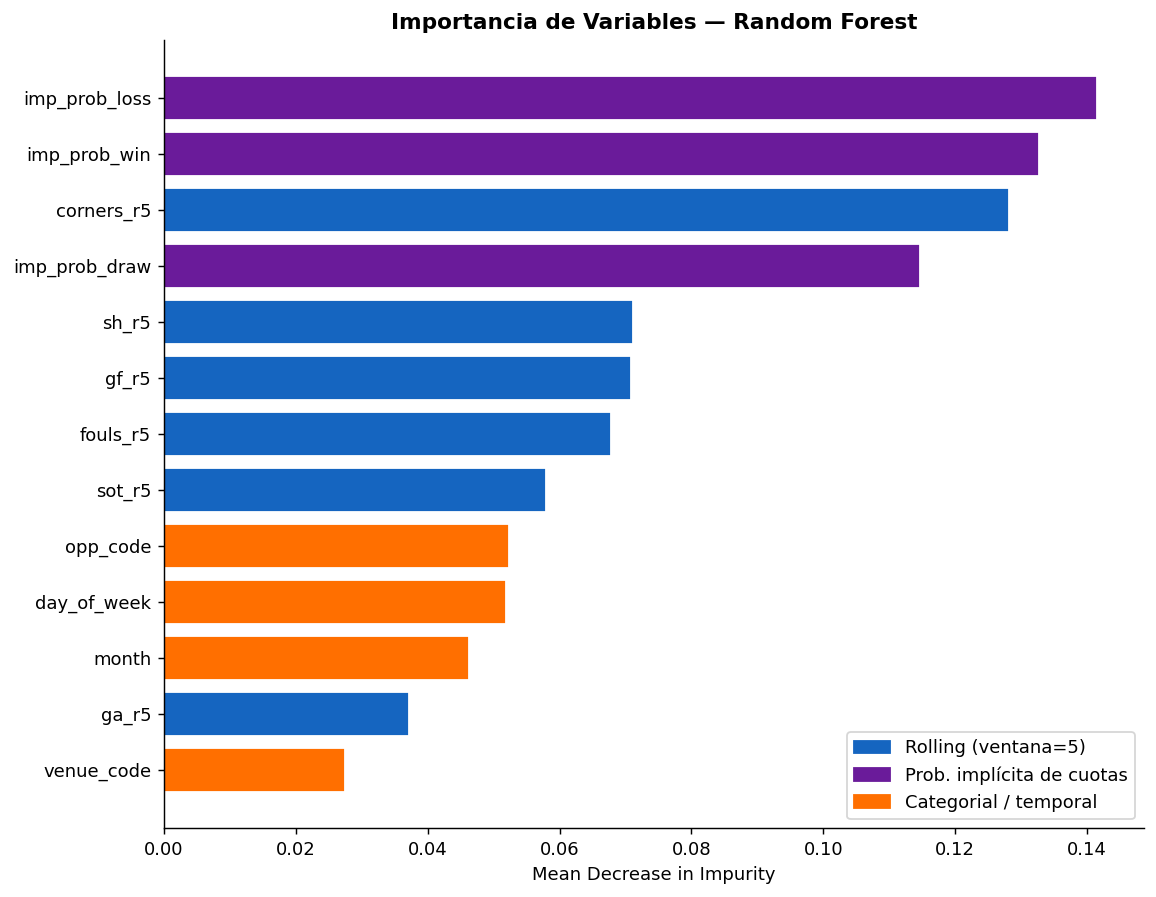


Top 5 features:
imp_prob_loss    0.1415
imp_prob_win     0.1327
corners_r5       0.1281
imp_prob_draw    0.1147
sh_r5            0.0712


In [10]:
imp = pd.Series(rf.feature_importances_, index=FEATURES).sort_values()

def feat_color(name):
    if '_r' in name:       return '#1565C0'   # rolling
    if 'imp_prob' in name: return '#6A1B9A'   # cuotas
    return '#FF6F00'                           # categorial/temporal

fig, ax = plt.subplots(figsize=(9, 7))
ax.barh(imp.index, imp.values,
        color=[feat_color(f) for f in imp.index], edgecolor='white')
ax.set_title('Importancia de Variables — Random Forest', fontweight='bold')
ax.set_xlabel('Mean Decrease in Impurity')
ax.legend(handles=[
    mpatches.Patch(color='#1565C0', label=f'Rolling (ventana={CFG.roll_window})'),
    mpatches.Patch(color='#6A1B9A', label='Prob. implícita de cuotas'),
    mpatches.Patch(color='#FF6F00', label='Categorial / temporal'),
])
plt.tight_layout()
plt.show()

print('\nTop 5 features:')
print(imp.tail(5)[::-1].round(4).to_string())


## 9 · Serialización del modelo

El artefacto incluye el modelo, la lista de features, las métricas
y metadatos de versión. Al cargar podemos verificar compatibilidad
antes de usar el modelo en producción.


In [11]:
import sklearn
from datetime import datetime, timezone

artifact = {
    'model':           rf,
    'features':        FEATURES,
    'target_map':      {'W': 1, 'D': 0, 'L': -1},
    'config':          CFG,
    'metrics': {
        'cv_f1_macro_mean':  float(cv_scores.mean()),
        'cv_f1_macro_std':   float(cv_scores.std()),
        'holdout_f1_macro':  float(test_f1),
        'baseline_f1_macro': float(baseline_f1),
        'improvement':       float(test_f1 - baseline_f1),
    },
    'trained_on':      datetime.now(tz=timezone.utc).isoformat(),
    'sklearn_version': sklearn.__version__,
    'n_train':         int(len(X_train)),
    'n_test':          int(len(X_test)),
    'data_range': {
        'from': str(feat_df['date'].min().date()),
        'to':   str(feat_df['date'].max().date()),
    },
}

joblib.dump(artifact, CFG.model_path, compress=3)
size_kb = CFG.model_path.stat().st_size / 1024
log.info('Artefacto guardado → %s (%.0f KB)', CFG.model_path, size_kb)

# Verificación de carga
loaded = joblib.load(CFG.model_path)
assert loaded['features']        == FEATURES,          'Feature list mismatch'
assert loaded['sklearn_version'] == sklearn.__version__, 'sklearn version mismatch'

print(f'✅ Modelo guardado: {CFG.model_path}  ({size_kb:.0f} KB)')
print(f'\n{"─"*50}')
for k, v in loaded['metrics'].items():
    print(f'  {k:<28} {v:.4f}')
print(f'  {"entrenado":<28} {loaded["trained_on"]}')
print(f'  {"sklearn":<28} {loaded["sklearn_version"]}')


✅ Modelo guardado: models/rf_pipeline.joblib  (314 KB)

──────────────────────────────────────────────────
  cv_f1_macro_mean             0.4050
  cv_f1_macro_std              0.0711
  holdout_f1_macro             0.3985
  baseline_f1_macro            0.2688
  improvement                  0.1297
  entrenado                    2026-02-23T19:51:59.067004+00:00
  sklearn                      1.6.1


## 10 · Inferencia en producción

`MatchInput` y `PredictionOutput` son dataclasses tipados.  
La función `predict()` valida inputs, loguea cada inferencia
y maneja rivales desconocidos y cuotas faltantes de forma explícita.


In [12]:
from dataclasses import dataclass as dc


@dc
class MatchInput:
    venue:    str           # 'Home' | 'Away'
    opponent: str
    day:      int  = 5     # día de la semana (0=lun … 6=dom)
    month:    int  = 3
    rolling:  Optional[dict] = None  # {stat: valor}; None → medianas históricas
    odds:     Optional[dict] = None  # {'win': 1.5, 'draw': 3.8, 'loss': 6.0}


@dc
class PredictionOutput:
    result:     str    # 'Victoria' | 'Empate' | 'Derrota'
    code:       int    # 1 | 0 | -1
    prob_win:   float
    prob_draw:  float
    prob_loss:  float
    confidence: str    # 'Alta' | 'Media' | 'Baja'
    warning:    str = ''


def predict(match: MatchInput, artifact: dict) -> PredictionOutput:
    if match.venue not in ('Home', 'Away'):
        raise ValueError(f"venue debe ser 'Home' o 'Away', recibido: {match.venue!r}")

    model    = artifact['model']
    features = artifact['features']
    warnings_ = []

    # Rival desconocido → código -1, con warning
    opp_map  = feat_df.set_index('opponent')['opp_code'].to_dict()
    opp_code = opp_map.get(match.opponent, -1)
    if opp_code == -1:
        msg = f"Rival desconocido '{match.opponent}' — usando opp_code=-1"
        log.warning(msg)
        warnings_.append(msg)

    # Rolling: medianas históricas si no se proporcionan
    if match.rolling is None:
        roll_vals = train_df[ROLL_FEATS].median().to_dict()
        warnings_.append('Rolling no proporcionado — usando medianas históricas')
    else:
        roll_vals = {f'{k}_r{CFG.roll_window}': v for k, v in match.rolling.items()}

    # Cuotas → probabilidades implícitas
    if match.odds:
        raw   = {k: 1/v for k, v in match.odds.items() if v > 0}
        total = sum(raw.values())
        imp_win  = raw.get('win',  0) / total
        imp_draw = raw.get('draw', 0) / total
        imp_loss = raw.get('loss', 0) / total
    else:
        imp_win  = train_df['imp_prob_win'].median()
        imp_draw = train_df['imp_prob_draw'].median()
        imp_loss = train_df['imp_prob_loss'].median()
        warnings_.append('Cuotas no proporcionadas — usando medianas históricas')

    row = {
        'venue_code':    1 if match.venue == 'Home' else 0,
        'opp_code':      opp_code,
        'day_of_week':   match.day,
        'month':         match.month,
        'imp_prob_win':  imp_win,
        'imp_prob_draw': imp_draw,
        'imp_prob_loss': imp_loss,
        **roll_vals,
    }
    X     = pd.DataFrame([row])[features]
    pred  = model.predict(X)[0]
    proba = dict(zip(model.classes_, model.predict_proba(X)[0]))
    pw, pd_, pl = proba.get(1, 0.), proba.get(0, 0.), proba.get(-1, 0.)
    max_p       = max(pw, pd_, pl)
    confidence  = 'Alta' if max_p > 0.60 else ('Media' if max_p > 0.45 else 'Baja')
    label       = {1: 'Victoria', 0: 'Empate', -1: 'Derrota'}[pred]

    out = PredictionOutput(
        result=label, code=pred,
        prob_win=pw, prob_draw=pd_, prob_loss=pl,
        confidence=confidence, warning=' | '.join(warnings_),
    )
    log.info('[PREDICT] %s vs %s (%s) → %s (conf=%s, P_W=%.2f P_D=%.2f P_L=%.2f)',
             CFG.team, match.opponent, match.venue,
             out.result, out.confidence, out.prob_win, out.prob_draw, out.prob_loss)
    return out


# ── Ejemplos de uso ───────────────────────────────────────────────────────────
loaded = joblib.load(CFG.model_path)
recent = feat_df.tail(CFG.roll_window)[list(CFG.stat_cols)].mean().round(2).to_dict()

test_matches = [
    MatchInput('Home', 'Barcelona',
               day=5, month=3, rolling=recent,
               odds={'win': 1.60, 'draw': 3.80, 'loss': 5.50}),
    MatchInput('Away', 'Atletico Madrid',
               day=6, month=4, rolling=recent,
               odds={'win': 2.10, 'draw': 3.30, 'loss': 3.40}),
    MatchInput('Home', 'Osasuna',
               day=6, month=2, rolling=recent,
               odds={'win': 1.20, 'draw': 6.00, 'loss': 14.0}),
    MatchInput('Away', 'Bayern Munich',   # rival desconocido
               day=2, month=4, rolling=recent,
               odds={'win': 2.80, 'draw': 3.20, 'loss': 2.50}),
    MatchInput('Home', 'Real Betis'),     # sin rolling ni cuotas
]

print(f'{"Partido":<38} {"Pred":10} {"Conf":7} {"P(W)":7} {"P(D)":7} {"P(L)":6}')
print('─' * 77)
for m in test_matches:
    o = predict(m, loaded)
    p = f'Real Madrid vs {m.opponent} ({m.venue})'
    print(f'{p:<38} {o.result:10} {o.confidence:7} '
          f'{o.prob_win:.2%}  {o.prob_draw:.2%}  {o.prob_loss:.2%}')
    if o.warning:
        print(f'  ⚠️  {o.warning}')


Partido                                Pred       Conf    P(W)    P(D)    P(L)  
─────────────────────────────────────────────────────────────────────────────


Real Madrid vs Barcelona (Home)        Victoria   Media   51.17%  35.63%  13.20%
Real Madrid vs Atletico Madrid (Away)  Victoria   Media   47.43%  21.91%  30.66%
  ⚠️  Rival desconocido 'Atletico Madrid' — usando opp_code=-1


Real Madrid vs Osasuna (Home)          Victoria   Media   59.11%  39.74%  1.16%


Real Madrid vs Bayern Munich (Away)    Victoria   Media   49.25%  14.24%  36.51%
  ⚠️  Rival desconocido 'Bayern Munich' — usando opp_code=-1
Real Madrid vs Real Betis (Home)       Victoria   Alta    70.23%  12.09%  17.68%
  ⚠️  Rival desconocido 'Real Betis' — usando opp_code=-1 | Rolling no proporcionado — usando medianas históricas | Cuotas no proporcionadas — usando medianas históricas
